In [1]:
%pylab inline
gray()

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

# Install Torch

Follow the instructions **appropriate for your system**
https://pytorch.org/get-started/locally/ 

On _your laptops_ which probably DO NOT have CUDA
```bash
conda install -y pytorch-cpu torchvision-cpu -c pytorch
```

**The next example is for a GPU system, do NOT do both(!)**

On _my_ system (GTX1080 GPU, NVIDIA Cuda v9.0)
```bash
conda install -y pytorch torchvision -c pytorch
```


**Restart the notbook** so that the python interpreter can process some of the changes made during installation of torchvision. 

In [2]:
import torch

In [3]:
import torchvision

# An Example

In [4]:
from torchvision.datasets import MNIST

In [5]:
training_data = MNIST('./mndist', train=True,  download=True)

In [6]:
training_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./mndist
    Transforms (if any): None
    Target Transforms (if any): None

In [7]:
??torch.utils.data.Dataset

In [8]:
training_data[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FAB32D89940>, tensor(5))

In [9]:
im, target = training_data[0]

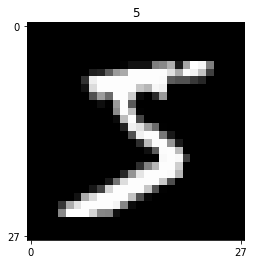

In [10]:
imshow(im);
title(int(target));
xticks([0, im.size[1]-1]);
yticks([0, im.size[0]-1]);

In [11]:
from torchvision import transforms

In [12]:
??transforms.ToTensor

In [13]:
??transforms.Compose

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor()])

In [15]:
training_data = MNIST('./mndist', train=True,  download=True, transform=transform)

In [16]:
data, target = training_data[0]
#data
print(type(data), type(target))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [17]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size=4, shuffle=True, num_workers=2)

In [18]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


In [19]:
train_iter = iter(train_loader)
images, targets = train_iter.next()

In [20]:
images.shape

torch.Size([4, 1, 28, 28])

In [21]:
targets.shape

torch.Size([4])

In [22]:
def show_batch(images, targets):
    ncols = ceil(sqrt(len(images)))
    nrows = ceil(len(images)/ncols)
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].numpy().squeeze())
        xticks([]); yticks([]); 
        if targets is not None:
            xlabel(str(targets[i].numpy()))

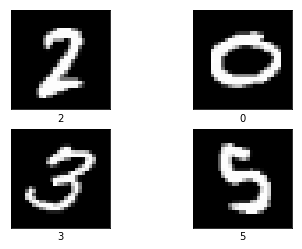

In [23]:
show_batch(images, targets)

In [24]:
import torch.nn as nn
import torch.nn.functional as F

In [25]:
x = images
x.shape

torch.Size([4, 1, 28, 28])

In [26]:
x = x.reshape(x.shape[0], -1)
x.shape

torch.Size([4, 784])

In [27]:
fc = nn.Linear(784, 10)
fc

Linear(in_features=784, out_features=10, bias=True)

In [28]:
W, b = fc.parameters()
W.shape, b.shape

(torch.Size([10, 784]), torch.Size([10]))

(0, 50)

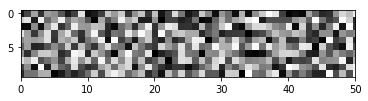

In [29]:
imshow(W.detach().numpy())
xlim(0,50)

In [30]:
a = fc(x)
a.shape

torch.Size([4, 10])

(0, 1)

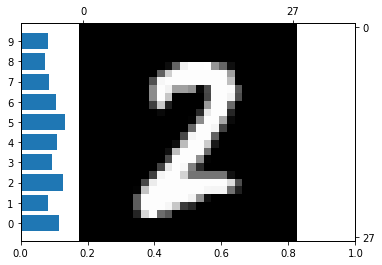

In [69]:
ax = gca()
twinx()
twiny()
imshow(images[0,0].numpy())
xticks([0,27])
yticks([0,27])
sca(ax)
barh(arange(10), F.softmax(a, dim=1).detach().numpy()[0])
yticks(arange(10));
xlim(0,1)

In [39]:
y = a.argmax(1)
y.shape

torch.Size([4])

In [40]:
def show_batch(images, targets, predictions=None):
    ncols = ceil(sqrt(len(images)))
    nrows = ceil(len(images)/ncols)
    for i in range(len(images)):
        subplot(nrows, ncols, i+1)
        imshow(images[i].numpy().squeeze())
        xticks([]); yticks([]); 
        if predictions is not None:
            xlabel("P:{}, T:{}".format( predictions[i].numpy(), targets[i].numpy()))
        elif targets is not None:
            xlabel("T:{}".format(targets[i].numpy()))


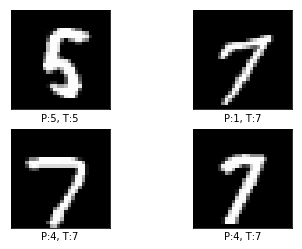

In [41]:
show_batch(images, targets, y)

In [45]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        a = self.fc(x)
        return a  # Will learn to treat 'a' as the natural parameters of a multinomial distr. 

In [46]:
import torch.optim as optim

net = MyNet()

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Will discuss lr and momentum later

While the next cell is running, open up a terminal and type `nvidia-smi` to make sure you are using 100% of your GPU. This is not so important on such a small dataset / model, but for larger problems the (linear) time sivings add up. 

In [49]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 0.302
[1,  4000] loss: 0.311
[1,  6000] loss: 0.291
[1,  8000] loss: 0.300
[1, 10000] loss: 0.317
[1, 12000] loss: 0.290
[1, 14000] loss: 0.295
[2,  2000] loss: 0.305
[2,  4000] loss: 0.296
[2,  6000] loss: 0.295
[2,  8000] loss: 0.286
[2, 10000] loss: 0.292
[2, 12000] loss: 0.273
[2, 14000] loss: 0.293
Finished Training


In [50]:
y = net(images).argmax(1)

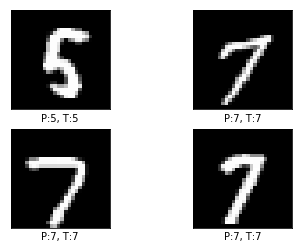

In [51]:
show_batch(images, targets, y)

**ALERT: This was ALL on TRAINING data -- we NEED TEST!!!***

In [ ]:
test_data = MNIST('./mndist', train=False,  download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, num_workers=2)

In [ ]:
with torch.no_grad():
    cm = np.zeros((10,10), dtype=np.int64)
    for x, y in iter(test_loader):
        p = net(x).argmax(1).numpy()
        for pred, true in zip(p, y):
            cm[int(pred), int(true)] += 1

In [ ]:
import pandas as pd
df_cm = pd.DataFrame(cm, index = arange(10), columns = arange(10))
df_cm

Install $\texttt{seaborn}$ to plot confusion matrices (and many other things) easily.   

In [ ]:
import seaborn as sn

In [ ]:
figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='d', annot=True);
ylabel('pred')
xlabel('true');

In [ ]:
acc = np.trace(cm)/ np.sum(cm)
acc

In [ ]:
def report_from_cm(cm, labels, beta=1):
    df = pd.DataFrame(index=list(labels)+['avg/total'], columns=['precision', 'recall', 'fmeasure','support'])
    for i, label in enumerate(labels):
        tp = cm[i,i]
        p = cm[i,:].sum()
        support = cm[:,i].sum()
        fp = p-tp
        fn = support-tp
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        fmeasure = (1+beta**2)*precision*recall/((beta**2)*precision + recall)
        df['precision'][label] = precision
        df['recall'][label] = recall
        df['fmeasure'][label] = fmeasure
        df['support'][label] = support
    df['precision']['avg/total'] = df['precision'][:'avg/total'].mean()
    df['recall']['avg/total'] = df['recall'][:'avg/total'].mean()
    df['fmeasure']['avg/total'] = df['fmeasure'][:'avg/total'].mean()
    df['support']['avg/total'] = df['support'][:'avg/total'].sum()
    return df

In [ ]:
report_from_cm(cm, range(10))

In [ ]:
net.state_dict()

In [ ]:
# Convention: Extention 'pth' seems to be from PyTorcH. Files are compressed with tar

In [ ]:
torch.save(net.state_dict(), 'mnist-linear.pth.tar')

In [ ]:
# To resume later
net.load_state_dict(torch.load('mnist-linear.pth.tar'))

In [ ]:
torch.save??

I typically write a class for doing the training. 

* I calculate test-loss every epoch
* I produce a plot of the running train /test losses
* I look for indications that there was a problem (NaN's, dead layers) after each epoch
* I save the model to a file (checkpoint.pth.tar) every epoch
    * If diskspace is not an issue, I save all of the checkpoints. This lets me go back and visualize how the net changed during learning
* I save the best model to a file (best.pth.tar) if it changes at each epoch
* I save the entire history to a log file
* I use progressbars from https://pypi.org/project/tqdm/ for each epoch


A training _curriculum_ will train multiple times, on increasingly complex versions of the problem. 
* Start with small images [8x8] and then increase the size
* Start with one layer, then add more
* Start with a pretrained model and freeze only the output, or input, layers initially. 

Next:
- Look at https://github.com/pytorch/tnt
- Look at https://github.com/ncullen93/torchsample